# Import library and data

In [1]:
import scipy.io
import numpy as np
import torch, os
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import seaborn as sns
import matplotlib.pyplot as plt


mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']
del mat

# Change output format

In [2]:
y_a = np.zeros((10,5000)).astype('int32')
y_temp = np.where(y==10,0,y)
for i in range(5000):
    y_a[y_temp[i],i] = 1
y_a = (np.r_[y_a[1:,:], y_a[0,:].reshape(1,-1)].T)

# Plot 20 images randomly

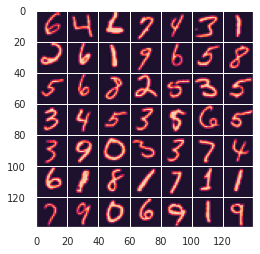

In [26]:
def img_out(X_array,loc):
    return X_array[loc,:].reshape((20,-1)).T
plot_sqr = 7
img = np.zeros((plot_sqr*20,plot_sqr*20))
img_index = np.random.randint(0,high=X.shape[0],size=plot_sqr**2)
img_tmp = [X[i,:].reshape((20,-1)).T for i in img_index]
for i in range(plot_sqr):
    img[:,i*20:(i+1)*20,] =(np.array(img_tmp[i*plot_sqr:(i+1)*plot_sqr]).reshape((-1,20)))
plt.imshow(img)

# Move dataset to dataloadert

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_a = torch.from_numpy(X.astype(np.float32)).to(device)
y_x = (torch.from_numpy(y_a.astype(np.float32))).to(device)

dataset = TensorDataset(X_a, y_x)

test_ratio = 0.2  # 20% data split into test dataset
n_sample,n_feature = X_a.shape
test_size = int(n_sample * test_ratio)
train_size = n_sample - test_size
train_ds, test_ds = random_split(dataset,[train_size, test_size])
train_dataloader = DataLoader(train_ds, batch_size=train_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=test_size)

# Create neural network class
shape of the NN 400,10 (hidden layer 1),10 (hidden layer 2), 10 (output layer)

In [4]:
class NumberNN(nn.Module):
    def __init__(self):
        super(NumberNN, self).__init__()
        layer1_out = 10
        layer2_out = 10
        self.layer1 = nn.Linear(400,layer1_out,bias=True)
        self.layer2 = nn.Linear(layer1_out,layer2_out,bias=True)
        self.output = nn.Linear(layer2_out,10,bias=True)

    def forward(self, x):
        z = torch.relu(self.layer1(x))
        z = torch.relu(self.layer2(z))
        z = torch.sigmoid(self.output(z))
        return z

# Load, Train, and Save

In [5]:
model = NumberNN().to(device)
if os.path.exists('NN_number_classification.pt'):
    model.load_state_dict(torch.load('NN_number_classification.pt'))
    epoch_max = 100
    report = 10
    print('Load model from file')
else:
    epoch_max = 10000
    report = 500
loss = nn.BCELoss()
rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=rate,weight_decay=1e-3)
for i in range(epoch_max):
    for x_batch_train, y_batch_train in train_dataloader:
        z = model(x_batch_train)
        J = loss(z,y_batch_train)
        J.backward()
        optimizer.step()
        optimizer.zero_grad()
    if i % report  == 0:
        with torch.no_grad():
            acc = (1-(z.round()-y_batch_train).abs().mean().item())*100
            for x_batch_test, y_batch_test in test_dataloader:
                zx = model(x_batch_test)
                acc_test = (1-(zx-y_batch_test).abs().mean().item())*100
        print(f'Epoch {i}: Cost = {J.item():.4f}, train acc = {acc:.4f}%, test acc = {acc_test:.4f}%')

torch.save(model.state_dict(),'NN_number_classification.pt')

Load model from file
Epoch 0: Cost = 0.0421, train acc = 98.8650%, test acc = 96.9820%
Epoch 10: Cost = 0.0414, train acc = 98.9075%, test acc = 96.9391%
Epoch 20: Cost = 0.0409, train acc = 98.9225%, test acc = 96.8814%
Epoch 30: Cost = 0.0406, train acc = 98.9375%, test acc = 96.8372%
Epoch 40: Cost = 0.0404, train acc = 98.9500%, test acc = 96.8056%
Epoch 50: Cost = 0.0402, train acc = 98.9600%, test acc = 96.7844%
Epoch 60: Cost = 0.0401, train acc = 98.9650%, test acc = 96.7681%
Epoch 70: Cost = 0.0399, train acc = 98.9675%, test acc = 96.7552%
Epoch 80: Cost = 0.0398, train acc = 98.9750%, test acc = 96.7440%
Epoch 90: Cost = 0.0398, train acc = 98.9750%, test acc = 96.7360%


# Create a confusion matrix

In [6]:
with torch.no_grad():
    z = model(X_a).cpu().detach().numpy()
confusion_matrix = np.zeros((10,10),dtype=int)
z0 = np.argmax(z,axis=1)+1
z_val = np.where(z0==10,0,z0)
y0 = y.flatten()
y_val = np.where(y0==10,0,y0)
for i,val in enumerate(y_val):
    confusion_matrix[y_val[i],z_val[i]] +=1

# Plot the confusion matrix

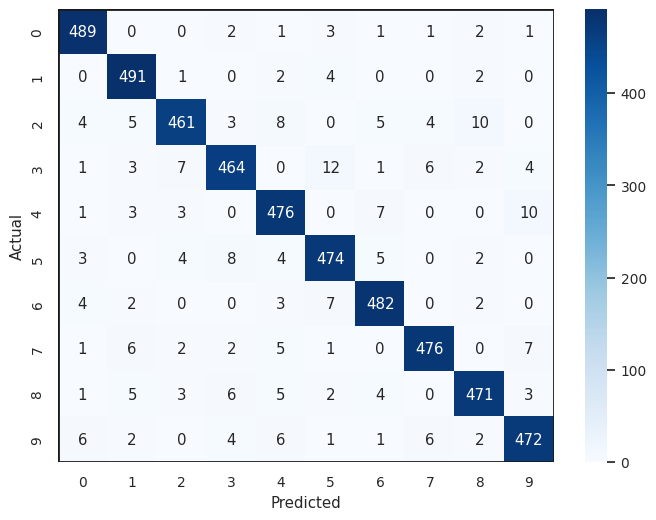

In [23]:
plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(confusion_matrix, annot=True,cmap='Blues', fmt='g')
ax.set(xlabel ='Predicted',ylabel='Actual')
ax.axhline(y=0, color='k',linewidth=2)
ax.axhline(y=10, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=10, color='k',linewidth=2)

# Create report of machine learning

In [24]:
print ("{:<8} {:<10} {:<10} {:<10}".format('Num','Precision','Recall','F1 Score'))
for i in range(10):
    precision = confusion_matrix[i,i] / confusion_matrix[i,:].sum()
    recall = confusion_matrix[i,i] / confusion_matrix[:,i].sum()
    f1 = 2*precision*recall/(precision+recall)
    print ("{:<8} {:<10} {:<10} {:<10}".format(i,round(precision,4),round(recall,4),round(f1,4)))

Num      Precision  Recall     F1 Score  
0        0.978      0.9588     0.9683    
1        0.982      0.9497     0.9656    
2        0.922      0.9584     0.9399    
3        0.928      0.9489     0.9383    
4        0.952      0.9333     0.9426    
5        0.948      0.9405     0.9442    
6        0.964      0.9526     0.9583    
7        0.952      0.9655     0.9587    
8        0.942      0.9554     0.9486    
9        0.944      0.9497     0.9468    
